<a href="https://colab.research.google.com/github/Gregory-lab-eng/python_Vistula/blob/main/Strakhov_75209_GPT2_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Poniższy kod służy do przetestowania procesu tokenizacji i detokenizacji modelu jezykowego opartego na architekturze transformera, z mechanizmem atencji

In [ ]:
#import niezbednych pakietow i bibliotek
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
#zaladowanie modelu na dostepne urzadzenie CPU lub GPU (cuda:0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [ ]:
#wydruk parametrow modelu
###ZADANIE1: wyszukajcie znaczenia hiperparametrów modelu: wte, wpe, drop, c_attn, c_proj, c_fc, c_proj
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


(wte): Embedding(50257, 768)

(wpe): Embedding(1024, 768)

(drop): Dropout(p=0.1, inplace=False)

(c_attn): Conv1D(nf=2304, nx=768)

(c_proj): Conv1D(nf=768, nx=768)

(c_fc): Conv1D(nf=3072, nx=768)

(c_proj): Conv1D(nf=768, nx=3072)


In [ ]:
#zainicjowanie tokenizera
#ZADANIE2: Wyszukajcie informacji czym jest attention_mask oraz jakie jest jej zastosowanie
prompt = "Once upon a time"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[7454, 2402,  257,  640]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

attention_mask to tensor używany w modelach typu Transformer, który mówi modelowi, na które tokeny ma zwracać uwagę, a które ignorować.
attention_mask: tensor([[1, 1, 1, 1]]) - oznacza, że wszystkie cztery tokeny są ważne i żaden nie jest paddingiem.
Maska mówi mechanizmowi attention, które tokeny mogą patrzeć na które.
Bez niej model mógłby analizować śmieciowe dane. Maskowanie paddingu zmniejsza liczbę niepotrzebnych obliczeń i poprawia jakość gradientów.

In [ ]:
#inferencja - proces wyliczenia prawdopodobienstwa dla nastepnych tokenow
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)


torch.Size([1, 4, 50257])


In [ ]:
#selekcja tokenu o największym prawdopodobienstwa wystapienia jako kolejny
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(11, device='cuda:0')

In [ ]:
#zdekodowanie tokena do wartosci slownikowej
tokenizer.decode(next_token_id)

','

In [ ]:
#10 najbardziej prawdopodobnych tokenow dla indeksu i+1
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[',', ' the', ' I', ' he', ' there', ' in', ' it', ' when', ' of', ' they']

In [ ]:
#wydruk
###ZADANIE3: w wektorze tensora, czym jest ostatnia "cyfra" 11?
device = inputs["input_ids"].device

next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1)).to(device)],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]], device=device)],
        dim=1
    ),
}

print(next_inputs["input_ids"], next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"], next_inputs["attention_mask"].shape)


tensor([[7454, 2402,  257,  640,   11]], device='cuda:0') torch.Size([1, 5])
tensor([[1, 1, 1, 1, 1]], device='cuda:0') torch.Size([1, 5])


tensor([[7454, 2402,  257,  640,   11]]

Generowanie odpowiedzi z pętli - czyli w pełni działający HELPER

In [ ]:
NEXT_TOKENS = 50

In [ ]:
def generate_token(inputs):
    device = inputs["input_ids"].device

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]

    next_token_id = last_logits.argmax().to(device).reshape(1, 1)

    return next_token_id


In [ ]:
generated_tokens = []
next_inputs = inputs
durations_s = []

device = next_inputs["input_ids"].device

for _ in range(NEXT_TOKENS):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s.append(time.time() - t0)

    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id],
            dim=1
        ),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]], device=device)],
            dim=1
        ),
    }

    next_token = tokenizer.decode(next_token_id[0, 0].item())
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)


1.363699197769165 s
[',', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' beauty', ' and', ' great', ' danger', '.', ' The', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', ',', ' and', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', '.', ' The', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', ',', ' and', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' danger']


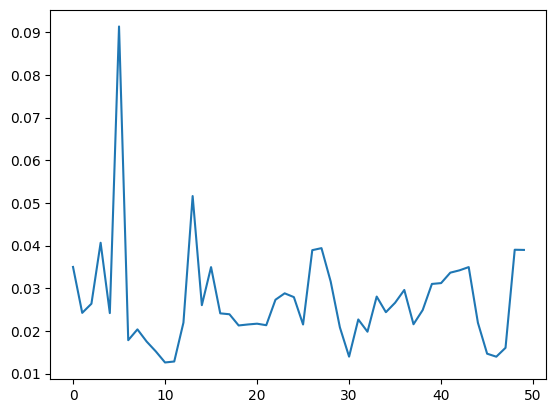

In [ ]:
plt.plot(durations_s)
plt.show()

HELPER z cacheowaniem KV (key value) - poniewaz nowo generowanie wektory nie zmieniaja sie, mozemy przechowywac je w cache w postaci key - value

In [ ]:
def generate_token_with_past(inputs):
    device = inputs["input_ids"].device

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]

    next_token_id = last_logits.argmax().to(device).reshape(1, 1)

    return next_token_id, outputs.past_key_values


In [ ]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []

device = next_inputs["input_ids"].device

for _ in range(NEXT_TOKENS):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    durations_cached_s.append(time.time() - t0)

    next_inputs = {
        "input_ids": next_token_id,
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]], device=device)],
            dim=1
        ),
        "past_key_values": past_key_values,
    }

    next_token = tokenizer.decode(next_token_id[0, 0].item())
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)


0.80023193359375 s
[',', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' beauty', ' and', ' great', ' danger', '.', ' The', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', ',', ' and', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', '.', ' The', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', ',', ' and', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' danger']


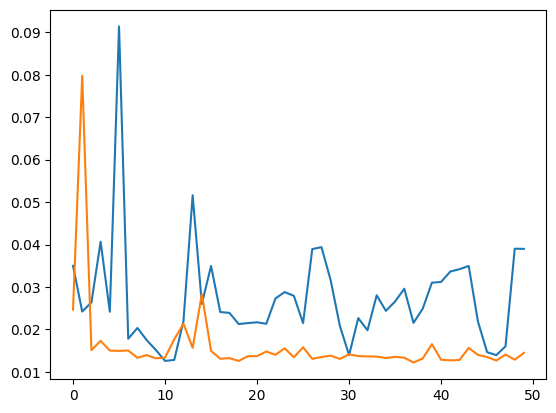

In [ ]:
plt.plot(durations_s) #podstawowy HELPER niebieski kolor
plt.plot(durations_cached_s) #HELPER z KV cache pomaranczony kolor
plt.show()

In [ ]:
###ZADANIE4: Zmiencie typ srodowiska wykonawczego na T4 GPU i wykonajcie jeszcze raz kod.
###- Pojawia sie 2 bledy, mowiace o tym, ze wszystkie tensory musza byc na tym samym urzadzeniu. Popprawcie te bledy.
###podpowiedz: tensory generowane przez tokenizer oraz attention_mask (torch.tensor) musza zostac offloadowane do urzadeznia device - uzyc metody to(device)

###ZADANIE5: Czy jestescie w stanie wyjasnic, dlaczego w przypadku GPU (T4 GPU) w zasadzie nie ma znaczenie uzycie KV cache?

T4 ma bardzo małą przepustowość pamięci (Memory Bandwidth)
To jest klucz.

T4: ~320 GB/s

A100: ~1555 GB/s

H100: ~3350 GB/s

KV‑cache przyspiesza modele tylko wtedy, gdy GPU potrafi szybko odczytywać i zapisywać duże macierze K i V.
Na T4 przepustowość jest tak niska, że:

czas odczytu KV‑cache ≈ czas ponownego przeliczenia attention bez cache

Czyli zysk znika.

# **Mechanizm atencji**

W tej sekcji znajdziesz 6 krótkich zadań dotyczących mechanizmu atencji i positional encoding.

> Wskazówka: każde zadanie ma przygotowany **szkielet kodu** z miejscami na uzupełnienie (`TODO`).

---

## Zadanie 1 (teoretyczne): Jak mnożenie macierzy Q, K, V buduje atencję?

**Polecenie:** Wyjaśnij własnymi słowami, jak iloczyny macierzy **QKᵀ** i późniejsze ważenie macierzą **V** tworzą mechanizm atencji.
W wyjaśnieniu uwzględnij:
- rolę macierzy **Q** (Query), **K** (Key), **V** (Value),
- interpretację elementów macierzy \(QK^T\) jako podobieństw,
- skalowanie przez \(\sqrt{d_k}\),
- działanie `softmax` i powstanie wag,
- końcowe ważenie wartości w \(\text{softmax}(QK^T/\sqrt{d_k})V\).

**Napisz odpowiedź tekstową w tej komórce (poniżej).**








*Twoja odpowiedź:*

1. Każdy token w zdaniu jest przekształcane przez trzy różne macierze wag:
- Q (Query) - reprezentuje pytanie, jakie dany token zadaje o kontekst.
- K (Key) - reprezentuje cechę, która pozwala innym tokenom zdecydować, czy są istotne.
- V (Value) - reprezentuje treść, którą token może przekazać, jeśli zostanie uznany za istotny.

2. Macierz:
(QK^T\)
Każdy element (i,j) tej macierzy to iloczyn wektorów:
Query tokenu i
Key tokenu j

Interpretacja:
Jeśli Qi i Kj  są do siebie podobne, wynik jest duży. Dlatego że mały kąt daję cosinus blizki do 1 w mnożeniu skalarnym.
Jeśli są niepodobne, wynik jest mały lub ujemny.

To jest miara tego, jak bardzo token i powinien zwracać uwagę na token j.

3. Wektory Q i K mają wymiar
dk.
Gdy ten wymiar jest duży, wartości iloczynów skalarnych rosną, co prowadzi do:
-bardzo dużych liczb,
-ekstremalnych wartości softmax,
-niestabilności numerycznej.
Dlatego dzielimy prez sqrt(dk)
To normalizuje wartości i stabilizuje softmax.

4. Softmax:
zamienia każdą linię macierzy w rozkład prawdopodobieństwa,
wartości dodatnie stają się większymi wagami,
wartości małe/ujemne stają się bliskie zera.
Efekt:
Każdy token dostaje zestaw wag mówiących, na które inne tokeny ma patrzeć i jak mocno.

5. Ważenie wartości V
Każdy wiersz softmaxu to wagi atencji dla jednego tokenu.
Mnożąc je przez macierz V, dostajemy:
ważoną sumę wartości V, gdzie wagi mówią, które tokeny są istotne.

To jest finalna reprezentacja kontekstowa tokenu — zawiera informację z innych tokenów, ale tylko tych, które były ważne.

In [ ]:
# [Zadanie 1: kod pomocniczy]
# Poniższy przykład ilustruje kroki obliczeń atencji dla małych macierzy.
# Uruchom, aby zobaczyć kolejne etapy – możesz modyfikować wartości i obserwować wpływ.

import torch
import torch.nn.functional as F

torch.manual_seed(42)

# N=liczba tokenów, d_k=wymiar cech
N, d_k = 4, 3
Q = torch.randn(N, d_k)
K = torch.randn(N, d_k)
V = torch.randn(N, d_k)

print("Q=\n", Q)
print("K=\n", K)
print("V=\n", V)

# 1) Surowe podobieństwa
scores = Q @ K.T
print("\n[1] QK^T =\n", scores)

# 2) Skalowanie
scores_scaled = scores / (d_k ** 0.5)
print("\n[2] QK^T / sqrt(d_k) =\n", scores_scaled)

# 3) Softmax (po wierszach)
weights = F.softmax(scores_scaled, dim=-1)
print("\n[3] softmax(...) = (wagi atencji)\n", weights)
print("Wiersze sumują się do 1:", weights.sum(dim=-1))

# 4) Ważenie wartości V
out = weights @ V
print("\n[4] Wyjście atencji = softmax(QK^T/sqrt(d_k)) V =\n", out)


Q=
 tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863],
        [ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]])
K=
 tensor([[ 1.1103, -1.6898, -0.9890],
        [ 0.9580,  1.3221,  0.8172],
        [-0.7658, -0.7506,  1.3525],
        [ 0.6863, -0.3278,  0.7950]])
V=
 tensor([[ 0.2815,  0.0562,  0.5227],
        [-0.2384, -0.0499,  0.5263],
        [-0.0085,  0.7291,  0.1331],
        [ 0.8640, -1.0157, -0.8887]])

[1] QK^T =
 tensor([[-0.0757,  0.6844, -0.0374,  0.3752],
        [ 2.3374, -1.4162,  0.4144,  0.3780],
        [ 3.0733,  1.6491, -0.5878,  2.0916],
        [-1.4075,  1.6247,  0.4884,  0.6516]])

[2] QK^T / sqrt(d_k) =
 tensor([[-0.0437,  0.3952, -0.0216,  0.2167],
        [ 1.3495, -0.8176,  0.2393,  0.2182],
        [ 1.7744,  0.9521, -0.3394,  1.2076],
        [-0.8126,  0.9380,  0.2820,  0.3762]])

[3] softmax(...) = (wagi atencji)
 tensor([[0.2053, 0.3184, 0.2099, 0.2664],
        [0.5661, 0.0648, 0.1865, 0.1826],
        [0.47

## Zadanie 2: Dodaj skalowanie \(1/\sqrt{d_k}\)

Masz szkic funkcji *scaled dot‑product attention*. **Drobna poprawka**: w miejscu oznaczonym `TODO` dodaj skalowanie wyników przez `1/sqrt(d_k)` **przed** softmaxem.


In [ ]:
import torch
import torch.nn.functional as F

def attention_no_scale(Q, K, V):
    # ZWRACA: (out, weights)
    # TODO: dodaj skalowanie 1/sqrt(d_k) przed softmaxem
    d_k = Q.size(-1)
    scores = Q @ K.T                    # [N, N]
    # TODO:
    scores_scaled = scores / (d_k ** 0.5)
    weights = F.softmax(scores, dim=-1) # po wierszach
    out = weights @ V
    weights_scaled = F.softmax(scores_scaled, dim=-1)
    out_scaled = weights_scaled @ V
    return out, weights, out_scaled, weights_scaled

torch.manual_seed(0)
Q = torch.randn(4, 3); K = torch.randn(4, 3); V = torch.randn(4, 3)
out, w, out_s, w_s = attention_no_scale(Q, K, V)
print("Wyjście (bez skalowania):\n", out)
print("Wagi (bez skalowania):\n", w)
print("Wyjście scalowane:\n", out_s)
print("Wagi scalowane:\n", w_s)


Wyjście (bez skalowania):
 tensor([[ 0.1676, -0.1597, -0.6427],
        [ 0.0816, -0.4867, -0.3615],
        [ 0.2441, -0.0552, -0.6961],
        [ 0.1849, -0.8154, -0.1597]])
Wagi (bez skalowania):
 tensor([[0.4834, 0.1533, 0.0426, 0.3207],
        [0.2017, 0.2846, 0.4461, 0.0676],
        [0.5688, 0.0739, 0.0223, 0.3350],
        [0.0977, 0.2315, 0.6115, 0.0592]])
Wyjście scalowane:
 tensor([[ 0.1333, -0.3217, -0.5525],
        [ 0.0775, -0.4657, -0.3982],
        [ 0.1947, -0.2635, -0.5873],
        [ 0.1261, -0.6716, -0.2749]])
Wagi scalowane:
 tensor([[0.3921, 0.2020, 0.0964, 0.3094],
        [0.2307, 0.2815, 0.3649, 0.1228],
        [0.4548, 0.1400, 0.0701, 0.3350],
        [0.1593, 0.2621, 0.4593, 0.1193]])


## Zadanie 3: Dodaj maskę atencji (causal lub padding)

**Drobna poprawka:** Uzupełnij obsługę maski w funkcji atencji.
- Jeżeli `mask` ma wartość 0 w pozycji \((i,j)\), to *zabroń* uwagi na \(j\) z \(i\) – ustaw tam dużą ujemną wartość **przed** softmaxem.


In [ ]:
import torch
import torch.nn.functional as F

def attention_with_mask(Q, K, V, mask=None):
    # ZWRACA: (out, weights)
    # mask: tensor [N, N] z wartościami 1 (dozwolone) lub 0 (zabronione)
    # TODO: zastosuj maskę PRZED softmaxem (użyj -1e9 dla miejsc zabronionych)
    d_k = Q.size(-1)
    scores = (Q @ K.T) / (d_k ** 0.5)
    if mask is not None:
        # TODO:
        scores = scores.masked_fill(mask == 0, -1e9)
        pass
    weights = F.softmax(scores, dim=-1)
    out = weights @ V
    return out, weights

# Przykład maski "causal" (trójkąt dolny)
N = 4
causal = torch.tril(torch.ones(N, N))
torch.manual_seed(1)
Q = torch.randn(N, 3); K = torch.randn(N, 3); V = torch.randn(N, 3)
out_m, w_m = attention_with_mask(Q, K, V, mask=causal)
print("Wagi (z maską causal):\n", w_m)


Wagi (z maską causal):
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4717, 0.5283, 0.0000, 0.0000],
        [0.3420, 0.4466, 0.2114, 0.0000],
        [0.3265, 0.2189, 0.2976, 0.1570]])


## Zadanie 4: Uproszczone Multi‑Head (2 głowy)

**Drobna poprawka:** Uzupełnij funkcję, by:
1. Rozdzielić Q, K, V na 2 głowy (połowa wymiaru na głowę),
2. policzyć atencję niezależnie dla każdej głowy,
3. scalić wyniki `torch.cat([...], dim=-1)`.

Załóż, że wymiar wejściowy jest parzysty.


In [ ]:
import torch
import torch.nn.functional as F

def split_heads(x, num_heads=2):
    # x: [N, d_model]
    N, d_model = x.shape
    assert d_model % num_heads == 0, "d_model musi być podzielny przez liczbę głów"
    d_head = d_model // num_heads
    # [N, num_heads, d_head]
    return x.view(N, num_heads, d_head)

def attention_simple(Q, K, V):
    d_k = Q.size(-1)
    scores = (Q @ K.T) / (d_k ** 0.5)
    weights = F.softmax(scores, dim=-1)
    return weights @ V, weights

def multi_head_two(Q, K, V):
    # TODO:
    # - rozdziel Q,K,V na 2 głowy,
    Qh = split_heads(Q, num_heads=2)
    Kh = split_heads(K, num_heads=2)
    Vh = split_heads(V, num_heads=2)
    outputs = []
    weights_list = []
    # - policz attention_simple na każdej głowie,
    for h in range(2):
        out_h, w_h = attention_simple(Qh[:, h, :], Kh[:, h, :], Vh[:, h, :])
        outputs.append(out_h)
        weights_list.append(w_h)
    # - sklej wyniki po ostatnim wymiarze i zwróć.
    out = torch.cat(outputs, dim=-1)
    # ZWRACA: (out, [weights_head0, weights_head1])
    return out, weights_list

torch.manual_seed(123)
Q = torch.randn(4, 6); K = torch.randn(4, 6); V = torch.randn(4, 6)
out, (w0, w1) = multi_head_two(Q, K, V)  # po uzupełnieniu odkomentuj
print("Wyjście Multi-Head (2):\n", out.shape)


Wyjście Multi-Head (2):
 torch.Size([4, 6])


## Zadanie 5: Dodaj sinusoidalny *positional encoding* do wejść

**Drobna poprawka:** Zaimplementuj funkcję `positional_encoding` i dodaj wyniki do `X` przed obliczeniem atencji.
Użyj wzoru:
\[
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right),\quad
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)
\]


In [ ]:
import math
import torch

def positional_encoding(n_pos, d_model):
    # ZWRACA: tensor [n_pos, d_model]
    # TODO: zaimplementuj sinusoidalny PE zgodnie z podanym wzorem.
    PE = torch.zeros(n_pos, d_model)
    positions = torch.arange(n_pos).unsqueeze(1)          # [n_pos, 1]
    div_terms = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

    # kanały parzyste: sinus
    PE[:, 0::2] = torch.sin(positions * div_terms)

    # kanały nieparzyste: cosinus
    PE[:, 1::2] = torch.cos(positions * div_terms)

    return PE

# Przygotuj sztuczne "wejścia" X oraz Q=K=V = X (self-attention)
N, d_model = 8, 6
torch.manual_seed(7)
X = torch.randn(N, d_model)

# TODO:
X_pe = X + positional_encoding(N, d_model)
# TODO:
out_pe, w_pe = attention_simple(X_pe, X_pe, X_pe)

print("Wyjście z PE:\n", out_pe)
print("Wagi z PE (kształt):", w_pe.shape)


Wyjście z PE:
 tensor([[-0.7285,  0.2320,  0.3257,  0.3539, -0.4248,  1.8869],
        [ 0.3736, -0.1386,  0.0768,  0.9387, -0.8606,  1.3746],
        [ 1.4091,  0.2692,  0.1866,  1.6450, -1.1854,  0.8997],
        [ 1.9799, -0.9421,  0.2715,  1.5355,  0.6685,  0.5555],
        [-0.9733, -0.7488, -1.0966,  0.6927, -1.5184,  1.9954],
        [-2.2242, -1.0535,  0.1113,  0.9357,  0.1288,  3.2462],
        [ 0.0964, -0.1543, -0.4247,  0.7407, -1.1350,  1.8901],
        [ 1.7923, -0.4734,  0.1468,  1.1917,  0.1702,  0.9647]])
Wagi z PE (kształt): torch.Size([8, 8])


## Zadanie 6: Zwizualizuj mapę wag atencji (matplotlib)

**Drobna poprawka:** Po obliczeniu wag `weights` narysuj mapę (heatmapę) z użyciem **matplotlib** (bez seaborn).
- Skorzystaj z `plt.imshow(weights.detach().numpy(), aspect='auto')`
- Dodaj tytuł i opisy osi.


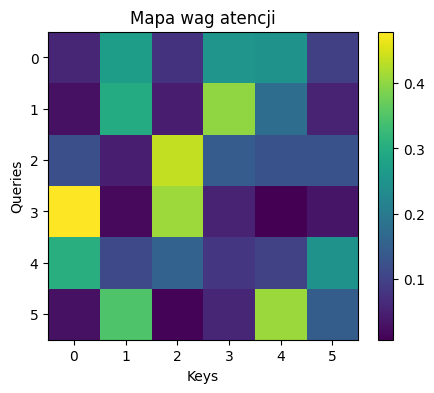

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(21)
Q = torch.randn(6, 4); K = torch.randn(6, 4); V = torch.randn(6, 4)
d_k = Q.size(-1)
weights = F.softmax((Q @ K.T) / (d_k ** 0.5), dim=-1)

# TODO: użyj matplotlib do narysowania heatmapy wag
# Przykład:
plt.figure(figsize=(5,4))
plt.imshow(weights.detach().numpy(), aspect='auto')
plt.title("Mapa wag atencji")
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.colorbar()
plt.show()


# **GPT2 fine-tuning**
Ćwiczenie bedzie polegalo na wytrenowaniu modelu na zestawie danym IMBD, tak azeby nauczyl sie klasyfikowac emocje zwiazanie z opiniami o filmach (ktore pojawily sie w komentarzach).

In [ ]:
#Instalacja pakietow
#W przypadku wystapienia bledu o niekompatybilnosci wersji fsspec, po prostu zignorujcie go.
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install transformers torch datasets

In [ ]:
#Załadowanie datasetu.
from datasets import load_dataset
dataset_raw = load_dataset("imdb")
dataset = dataset_raw

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
#załadowanie tokenizera i przepuszczenie datasetu przez tokenizer, aby otrzymac sekwencje tokenow (inferencja i trening/fine-tuning korzysta z tokenow)
###ZADANIE1: Wyjasnijnie w maksymalnie 250 slowach co oznacza padding oraz truncation. Dlaczego stosuje sie je w definicji funkcji tokenizera?
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
def tokenizer_func(input_ds):
    return tokenizer(input_ds["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenizer_func, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Padding polega na dopisywaniu specjalnych tokenów na końcu sekwencji, aby wyrównać jej długość do ustalonego maksimum.
Modele działają na tensorach o stałych wymiarach, więc jeśli jedno zdanie ma 12 tokenów, a inne 40, to bez paddingu nie dałoby się ich ułożyć w jedną macierz.

Truncation to obcinanie sekwencji, które są dłuższe niż maksymalna dopuszczalna długość.
Jeśli model może przyjąć maksymalnie 128 tokenów, a zdanie ma 200, to tokenizator skróci je do 128. Chroni to przed błędami i nadmiernym zużyciem pamięci. Truncation jest konieczne, bo modele mają twarde limity długości kontekstu.

Tokenizator musi przygotować dane tak, aby:
wszystkie sekwencje miały ten sam rozmiar (padding),
żadna sekwencja nie przekraczała maksymalnej długości modelu (truncation),
batchowanie było możliwe i wydajne,
model nie otrzymywał danych o niepoprawnym kształcie.

In [ ]:
#Zaladowanie biblioteki GPT2 do klasyfikacji oraz załadowanie modelu
###ZADANIE2: Opiszcie w maksymalnie 1000 słowach czym jest GPT2ForSequenceClassification ora jego działanie. Pomocny link: https://www.huggingface.co/transformers/v4.2.2/model_doc/gpt2.html#gpt2forsequenceclassification
from transformers import GPT2ForSequenceClassification
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2).to(device)
# Define the padding token for the model configuration
model.config.pad_token_id = model.config.eos_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification to wariant modelu GPT-2 dostępny w bibliotece HuggingFace Transformers, specjalnie dostosowany do zadań klasyfikacyjnych.
GPT-2 w swojej oryginalnej formie jest modelem generacyjnym (autoregresyjnym), zaprojektowanym do przewidywania kolejnego tokenu w sekwencji.
Wersja ForSequenceClassification rozszerza go o dodatkową warstwę klasyfikacyjną, dzięki czemu model może wykonywać zadania takie jak:

klasyfikacja sentymentu (pozytywny/negatywny),
klasyfikacja tematów,
wykrywanie intencji,
klasyfikacja toksyczności,
analiza emocji,
dowolne zadanie, w którym wejściem jest tekst, a wyjściem etykieta.

Model zachowuje całą architekturę GPT-2 (warstwy Transformer Decoder), ale na końcu dodaje liniową warstwę klasyfikacyjną, która przekształca reprezentację tekstu w predykcję klas.

Choć GPT-2 jest modelem generacyjnym, jego wewnętrzne reprezentacje są bogate semantycznie.
Ostatni token „widzi” całą sekwencję dzięki mechanizmowi self-attention, więc jego wektor zawiera informację o:
tonie wypowiedzi,
temacie,
stylu,
emocjach,
strukturze zdania.

Dodanie prostej warstwy klasyfikacyjnej pozwala wykorzystać tę reprezentację do przewidywania etykiet.

In [ ]:
#Inicjalizacja funkcji trenera i rozpoczecie treningu. Poeksperymentujcie z parametrem per_device_train_batch_size. Juz o tym wspominalem, ze jest to batchowanie danych wejsciowych do treningu - im wiekszy size, tym wiecej GPu VRAM potrzeba, ale tym szybszy trening, poniewaz nie tracimy czasu na najbardziej kosztowna czasowo operacje polegajaca na przeslaniu danych do VRAM.
###Zadanie3: Utworzcie konto w https://wandb.ai/home - jest to narzedzie Observability trenera. Generuje URL, pod ktorym mozna sledzic postepy treningu modelu.
###Po utworzeniu konta w wandb.ai, nalezy wygenerowac API key (nalezy stworzyc nowy projekt - w nowym projekcie API key wygeneruje sie automatycznie)

from transformers import Trainer, TrainingArguments
red_factor = 0.1
tr_ds_len = int((tokenized_datasets["train"].shape[0])*red_factor)
ev_ds_len = int((tokenized_datasets["train"].shape[0])*red_factor)

args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"].select(range(tr_ds_len)),
    eval_dataset=tokenized_datasets["test"].select(range(ev_ds_len)),
)

In [ ]:
#Uruchomienie trenera. Fine-tuning odbywa sie tylko na probce train datasetu
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: grzegorz-strachow (grzegorz-strachow-akademia-finans-w-i-biznesu-vistula) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.000600
1000,0.000000
1500,0.000000


TrainOutput(global_step=1875, training_loss=0.0001544266177690588, metrics={'train_runtime': 2184.0471, 'train_samples_per_second': 3.434, 'train_steps_per_second': 0.858, 'total_flos': 3919451258880000.0, 'train_loss': 0.0001544266177690588, 'epoch': 3.0})

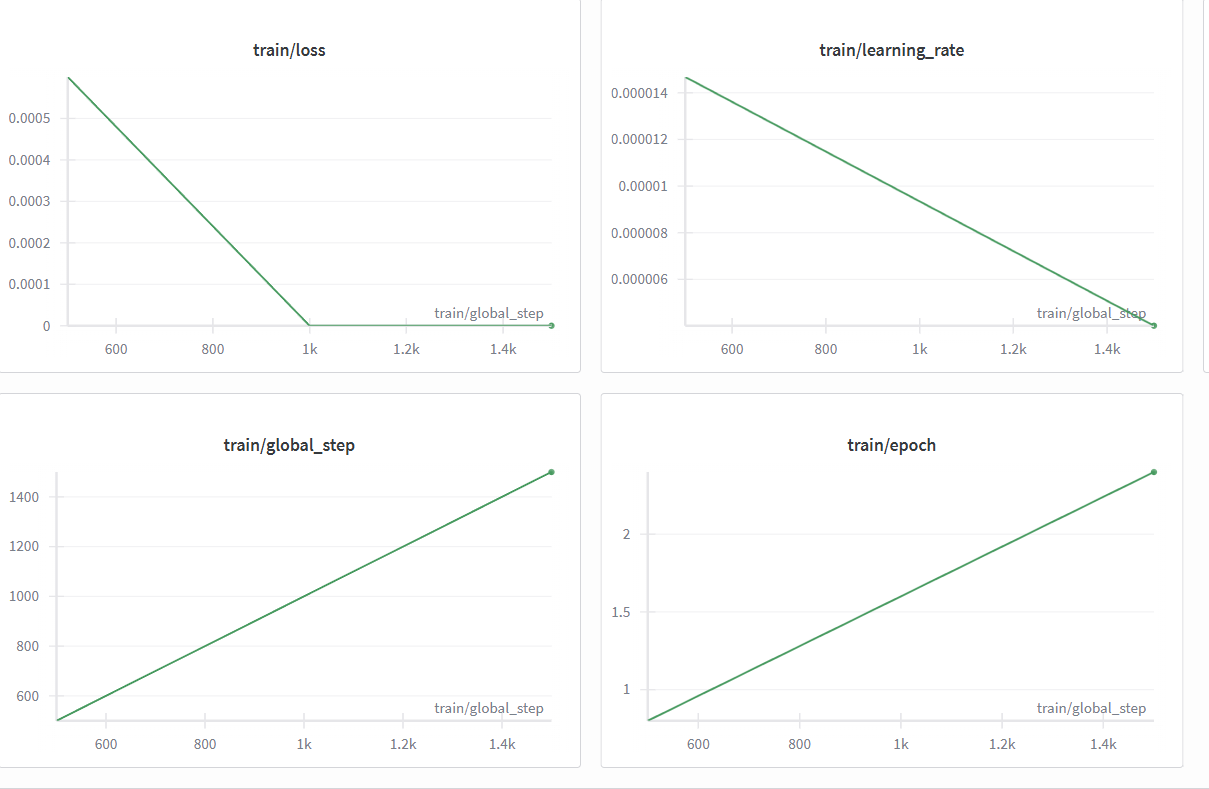

In [ ]:
#Instalacja akceleratorow przyspieszajacych (teoretycznie) dzialanie inferencji. Krok opcjonalny
!pip install accelerate
!pip install transformers torch -U
# Uruchomcie tylko raz, zrestartujcie i juz wiecej nie wykonujcie tego kodu (chyba ze zmieniacie startujecie srodowisko uruchomieniowe na nowo)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 870.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17

In [ ]:
#Wykonaj ewaluacje modelu (Dokladnosc modelu na bazie probki danych eval, ktore nie byly wykorzystane w fine-tuningu)
###ZADANIE4: Zinterpretujcie wyniki wyswietlone przez eval modelu
trainer.evaluate()

{'eval_loss': 3.622918427481636e-07,
 'eval_runtime': 176.1864,
 'eval_samples_per_second': 14.19,
 'eval_steps_per_second': 1.777,
 'epoch': 3.0}

eval_loss: 3.622918427481636e-07
To ekstremalnie niska wartość — w praktyce bliska zeru.

Co to oznacza:
model praktycznie nie popełnia błędów na zbiorze walidacyjnym,
przewidywania są niemal idealnie zgodne z etykietami,
może to sugerować bardzo dobre dopasowanie, ale też potencjalne przetrenowanie, jeśli zbiór walidacyjny jest mały lub zbyt podobny do treningowego.

eval_runtime: 176 sekund
To po prostu czas trwania ewaluacji.

eval_samples_per_second: 14.19
Model przetwarza około 14 próbek na sekundę podczas ewaluacji.

eval_steps_per_second: 1.777
Każdy „step” to przetworzenie jednego batcha.

epoch: 3.0
Ewaluacja została wykonana po trzeciej epoce treningu.

In [ ]:
###ZADANIE5: Przetestujcie model da kilku (5-10) wybranych sentencji i zapiszcie wynik klasyfikacji
def get_sentiment(sentence):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    outputs = model(**inputs)
    #prediction_sf = outputs.logits.softmax(-1).tolist()[0]
    prediction = outputs.logits.argmax(-1).item()
    return "pozytywna" if prediction == 1 else "negatywna"

sentences = [
    "I absolutely loved this movie, it was fantastic!",
    "This was the worst experience I've ever had.",
    "The product is okay, nothing special but not terrible.",
    "I'm really happy with the service I received.",
    "I'm not sure if I like it or not.",
    "The food was cold and tasted awful.",
    "What a wonderful surprise, I didn't expect it to be so good!",
    "It works fine, but I expected better quality.",
    "I'm extremely disappointed with the results."
]

for s in sentences:
    print(s, "-", get_sentiment(s))

I absolutely loved this movie, it was fantastic! - negatywna
This was the worst experience I've ever had. - negatywna
The product is okay, nothing special but not terrible. - negatywna
I'm really happy with the service I received. - negatywna
I'm not sure if I like it or not. - negatywna
The food was cold and tasted awful. - negatywna
What a wonderful surprise, I didn't expect it to be so good! - negatywna
It works fine, but I expected better quality. - negatywna
I'm extremely disappointed with the results. - negatywna


In [ ]:
###ZADANIE6: Zapewne zauważyliście, że nieważne co wpiszenie w pole sentence, i tak zawsze odpowiedz z modelu jest "negatywna".
###Czy jestescie w stanie wyjasnic, dlaczego fine-tuning modelu spowodowal, ze model i tak zawsze generalizuje do jednej odpowiedzi? Opiszcie swoje wytlumaczenie w max 250 slowach
###Wskazowka: Probem zbyt duzej generalizacji modelu jest bardzo czesty i lezy najczesniej w danych ... Sprawdzcie w danych co jest nie tak (chodzi o dane, ktore trafily do subsetu train_datase)

In [ ]:
from collections import Counter
labels = tokenized_datasets["train"]["label"]
print(Counter(labels))

Counter({0: 12500, 1: 12500})


In [ ]:
subset = tokenized_datasets["train"].select(range(tr_ds_len))
cnt = Counter(subset["label"])
print("Liczba 0:", cnt.get(0, 0))
print("Liczba 1:", cnt.get(1, 0))

Liczba 0: 2500
Liczba 1: 0


To oznacza jedno — w subsetcie treningowym nie ma ANI JEDNEGO przykładu klasy 1 czyli "pozitive"

wzieli
red_factor = 0.1 tr_ds_len = int((tokenized_datasets["train"].shape[0])*red_factor) train_dataset = tokenized_datasets["train"].select(range(tr_ds_len))

a wiele datasetów jest posortowanych po etykietach
więc trzeba robić shuffle przy probkowaniu